#### Import Libraries

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


#### Load Dataset

In [6]:
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")

print(train_df.shape, test_df.shape)
train_df.head()


(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Extract Features & Labels

In [7]:
X = train_df.iloc[:, 1:].values  # Extract pixel values
y = train_df.iloc[:, 0].values   # Extract labels

#### Reshape Images

In [8]:
X = X.reshape(-1, 1, 28, 28)  # Reshape to (num_samples, channels, height, width)

#### Normalize Data

In [9]:
X = X / 255.0  # Scale pixel values to [0,1]

#### Convert to PyTorch Tensors

In [10]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

#### Split into Train and Validation Sets

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#### Create DataLoaders

In [12]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)

#### Visualize Sample Images

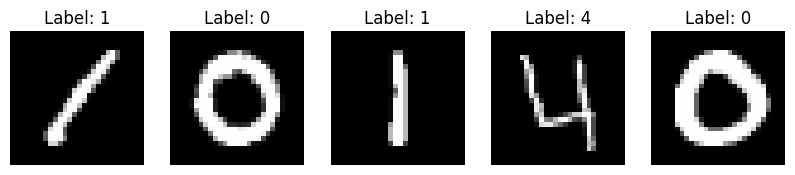

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i, 0], cmap="gray")
    ax.set_title(f"Label: {y[i].item()}")
    ax.axis("off")
plt.show()


#### Define CNN Architecture

##### We'll build a simple CNN with:

    - Conv Layer 1: 16 filters, 3×3
    - ReLU Activation
    - MaxPooling Layer: 2×2
    - Conv Layer 2: 32 filters, 3×3
    - ReLU Activation
    - MaxPooling Layer: 2×2
    - Flatten → Fully Connected Layer
    - Softmax for classification

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # 28x28 → 28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 → 14x14
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)  # 14x14 → 14x14
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # Flattened size: 7x7x32
        self.fc2 = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 → ReLU → Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 → ReLU → Pool
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))  # Fully connected
        x = self.fc2(x)  # Output (logits)
        return x

# Instantiate the model
model = CNN()


#### Forward Propagation

In [15]:
sample_image = X_train[0].unsqueeze(0)  # Add batch dimension
output = model(sample_image)
print("Raw Output:", output)
print("Predicted Label:", torch.argmax(output, dim=1).item())


Raw Output: tensor([[-0.0768,  0.1011, -0.0185,  0.0119,  0.0677,  0.0625,  0.0499, -0.0304,
         -0.0070, -0.0479]], grad_fn=<AddmmBackward0>)
Predicted Label: 1


#### Visualizing Activations

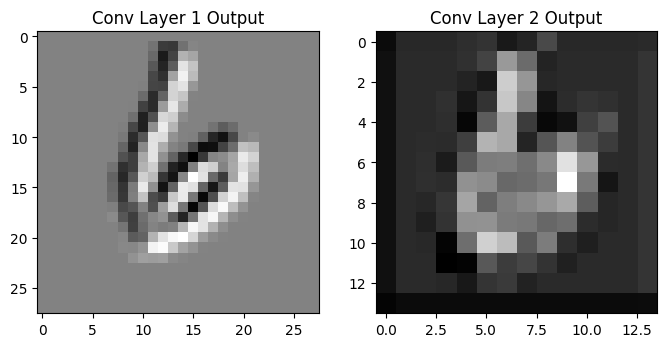

In [16]:
def visualize_activations(model, image):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    conv1_output = model.conv1(image.unsqueeze(0)).detach().numpy()[0]
    axes[0].imshow(conv1_output[0], cmap="gray")
    axes[0].set_title("Conv Layer 1 Output")
    
    conv2_output = model.conv2(model.pool(F.relu(model.conv1(image.unsqueeze(0))))).detach().numpy()[0]
    axes[1].imshow(conv2_output[0], cmap="gray")
    axes[1].set_title("Conv Layer 2 Output")
    
    plt.show()

visualize_activations(model, X_train[0])

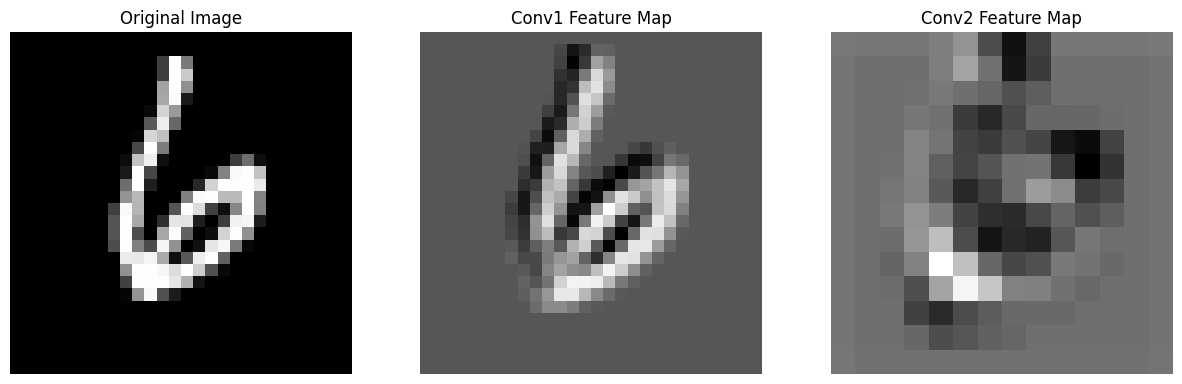

In [21]:
def visualize_forward(model, image):
    """
    Visualizes feature maps at different layers in forward propagation.
    """
    image = image.unsqueeze(0)  # Add batch dimension
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image[0, 0], cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # First Conv Layer
    conv1_output = model.conv1(image).detach().numpy()[0]
    axes[1].imshow(conv1_output[0], cmap="gray")
    axes[1].set_title("Conv1 Feature Map")
    axes[1].axis("off")

    # Second Conv Layer
    conv2_input = model.pool(F.relu(model.conv1(image)))
    conv2_output = model.conv2(conv2_input).detach().numpy()[0]
    axes[2].imshow(conv2_output[0], cmap="gray")
    axes[2].set_title("Conv2 Feature Map")
    axes[2].axis("off")

    plt.show()

# Run the function on a sample image
sample_image = X_train[0]  # Pick an image
visualize_forward(model, sample_image)


### Backward Propagation

#### Define Loss & Optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Backpropagation for a Sample Image

In [18]:
optimizer.zero_grad()  # Reset gradients
loss = criterion(output, torch.tensor([y_train[0]]))  # Compute loss
loss.backward()  # Backpropagation (computes gradients)
optimizer.step()  # Update weights
print("Backpropagation complete!")

Backpropagation complete!


#### Train the Model

In [19]:
num_epochs = 5

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/5], Loss: 0.3046
Epoch [2/5], Loss: 0.0773
Epoch [3/5], Loss: 0.0547
Epoch [4/5], Loss: 0.0412
Epoch [5/5], Loss: 0.0333


#### Evaluate the Model

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")


Validation Accuracy: 98.24%


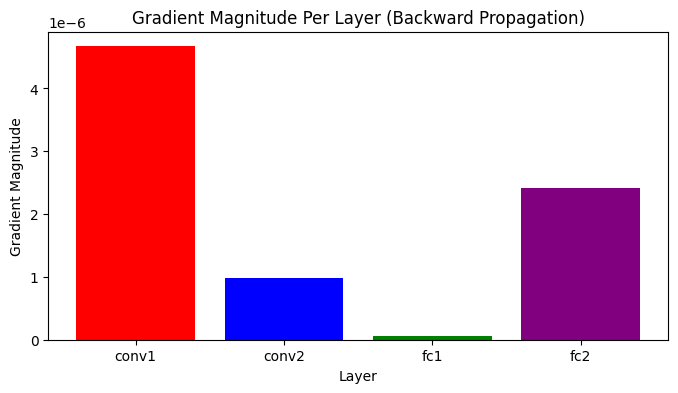

In [22]:
def visualize_backward(model, image, label):
    """
    Visualizes gradient magnitudes at different layers in backward propagation.
    """
    image = image.unsqueeze(0)  # Add batch dimension
    label = torch.tensor([label])
    
    optimizer.zero_grad()  # Reset gradients
    output = model(image)  # Forward pass
    loss = criterion(output, label)  # Compute loss
    loss.backward()  # Compute gradients

    # Extract gradients
    gradients = {
        "conv1": model.conv1.weight.grad.abs().mean().item(),
        "conv2": model.conv2.weight.grad.abs().mean().item(),
        "fc1": model.fc1.weight.grad.abs().mean().item(),
        "fc2": model.fc2.weight.grad.abs().mean().item(),
    }

    # Plot gradients
    plt.figure(figsize=(8, 4))
    plt.bar(gradients.keys(), gradients.values(), color=['red', 'blue', 'green', 'purple'])
    plt.xlabel("Layer")
    plt.ylabel("Gradient Magnitude")
    plt.title("Gradient Magnitude Per Layer (Backward Propagation)")
    plt.show()

# Run the function on a sample image
visualize_backward(model, sample_image, y_train[0].item())
